In [1]:
# Установка необходимых зависимостей
!pip install ultralytics
!pip install torch torchvision
!pip install albumentations

# Настройка CUDA для лучшего управления памятью
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Клонирование репозитория с обученной моделью
!git clone https://github.com/smicurin474/Car_plate_detecting.git

# Добавляем путь к репозиторию в PYTHONPATH
import sys
sys.path.append('/kaggle/working/Car_plate_detecting')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 17.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninst

In [2]:
# Загрузка датасета
!mkdir -p /kaggle/working/finetune_dataset
!wget https://huggingface.co/datasets/AY000554/Car_plate_detecting_dataset/resolve/main/train.zip
!wget https://huggingface.co/datasets/AY000554/Car_plate_detecting_dataset/resolve/main/val.zip

# Распаковка датасета
!unzip -q train.zip -d /kaggle/working/finetune_dataset
!unzip -q val.zip -d /kaggle/working/finetune_dataset

--2025-09-03 15:52:22--  https://huggingface.co/datasets/AY000554/Car_plate_detecting_dataset/resolve/main/train.zip
Resolving huggingface.co (huggingface.co)... 18.244.202.68, 18.244.202.60, 18.244.202.73, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.68|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/f5/fb/f5fb9d95f122eb06ad36fa568b80b423cda743737da1285f498b17999aee4770/689e09a59fd1ba57584e45896ae9d87a205a201080d23116362d41c5e1b805c3?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27train.zip%3B+filename%3D%22train.zip%22%3B&response-content-type=application%2Fzip&Expires=1756918342&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1NjkxODM0Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2Y1L2ZiL2Y1ZmI5ZDk1ZjEyMmViMDZhZDM2ZmE1NjhiODBiNDIzY2RhNzQzNzM3ZGExMjg1ZjQ5OGIxNzk5OWFlZTQ3NzAvNjg5ZTA5YTU5ZmQxYmE1NzU4NGU0NTg5NmFlOWQ4N2EyMDVhMjAxMDgwZD

In [4]:
# Создаем отдельную директорию для тестирования аугментаций на сложных случаях
!mkdir -p /kaggle/working/hard_cases_test/images
!cp -r /kaggle/working/Car_plate_detecting/hard_cases/* /kaggle/working/hard_cases_test/images/

print("Количество изображений для дообучения:", len(os.listdir('/kaggle/working/finetune_dataset/train/images')))
print("Количество изображений для валидации:", len(os.listdir('/kaggle/working/finetune_dataset/val/images')))
print("Количество сложных случаев для тестирования:", len(os.listdir('/kaggle/working/hard_cases_test/images')))

Количество изображений для дообучения: 20505
Количество изображений для валидации: 2563
Количество сложных случаев для тестирования: 37


Анализ сложных случаев:
--------------------------------------------------

BLUR: 8 случаев
Примеры:
  - 1407817_4b6111bb4c6a7b488d1fbaae0b914661_photo.jpg
  - 1051833_fdc4fc24282f6b4052aac00a3ca0000f_photo.jpg
  - 1399702_0f452608229dfa104d9473c520881a66_photo.jpg

DARK: 0 случаев

BRIGHT: 0 случаев

DIRTY: 33 случаев
Примеры:
  - 1049142_1a9445ffd3c4a2efac5bf0cf67cdf732_photo.jpg
  - 1403707_af61f7dc10024f6cdc213d517f2f8940_photo.jpg
  - 1407817_4b6111bb4c6a7b488d1fbaae0b914661_photo.jpg

ANGLE: 10 случаев
Примеры:
  - 1399702_0f452608229dfa104d9473c520881a66_photo.jpg
  - 1049158_ef870f58cb60feb1b8043cc4f89c2be5_photo.jpg
  - 1401013_191cc8f7c2d3ce252c038d49f0450545_photo.jpg

SHADOW: 1 случаев
Примеры:
  - 1401013_191cc8f7c2d3ce252c038d49f0450545_photo.jpg

PARTIAL: 0 случаев


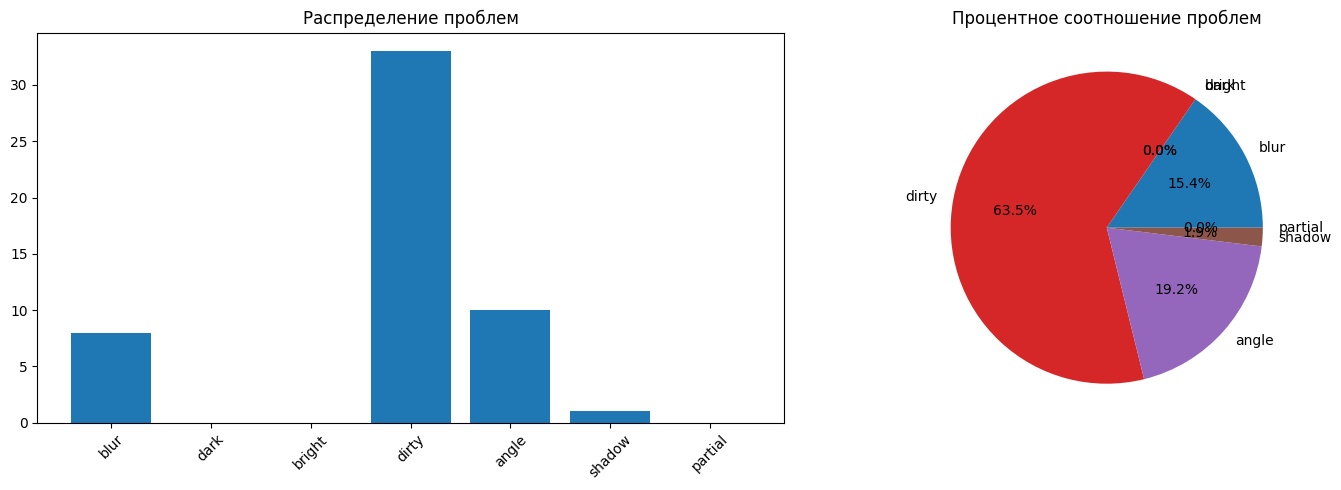

In [18]:
def analyze_hard_cases(hard_cases_dir):
    hard_cases_dir = Path(hard_cases_dir)
    hard_cases = list(hard_cases_dir.glob('*.jpg'))
    
    problems = {
        'blur': [],      # Размытые изображения
        'dark': [],      # Темные изображения
        'bright': [],    # Засвеченные изображения
        'dirty': [],     # Грязные/стертые номера
        'angle': [],     # Сильный угол наклона
        'shadow': [],    # Тени на номере
        'partial': []    # Частично закрытые номера
    }
    
    for img_path in hard_cases:
        img = cv2.imread(str(img_path))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 1. Анализ размытия (улучшенный)
        # Используем комбинацию методов
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        # Добавляем анализ высокочастотных компонент
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3).var()
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3).var()
        if laplacian_var < 100 or (sobelx + sobely) < 200:
            problems['blur'].append(img_path.name)
        
        # 2. Анализ грязи и стертости (новый метод)
        # Используем локальные области и анализ текстур
        local_std = []
        local_entropy = []
        for i in range(0, img.shape[0], 32):
            for j in range(0, img.shape[1], 32):
                patch = gray[i:i+32, j:j+32]
                if patch.size > 0:
                    local_std.append(np.std(patch))
                    hist = cv2.calcHist([patch], [0], None, [256], [0, 256])
                    hist = hist / hist.sum()
                    entropy = -np.sum(hist * np.log2(hist + 1e-7))
                    local_entropy.append(entropy)
        
        if np.mean(local_std) < 30 or np.mean(local_entropy) < 3:
            problems['dirty'].append(img_path.name)
        
        # 3. Анализ теней (улучшенный)
        # Используем адаптивную пороговую обработку
        binary = cv2.adaptiveThreshold(
            cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
            255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )
        black_ratio = 1 - np.mean(binary) / 255
        if black_ratio > 0.4:  # Если больше 40% темных пикселей
            problems['shadow'].append(img_path.name)
        
        # 4. Анализ яркого света/вспышек
        # Ищем области с высокой яркостью
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        v_channel = hsv[:, :, 2]
        if np.sum(v_channel > 250) > v_channel.size * 0.1:  # Если более 10% пикселей очень яркие
            problems['bright'].append(img_path.name)
        
        # 5. Анализ углов (улучшенный)
        edges = cv2.Canny(img, 100, 200)
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, 
                               minLineLength=100, maxLineGap=10)
        if lines is not None:
            angles = []
            for line in lines:
                x1, y1, x2, y2 = line[0]
                angle = np.abs(np.degrees(np.arctan2(y2-y1, x2-x1)))
                angles.append(angle)
            if np.std(angles) > 30:  # Большой разброс углов
                problems['angle'].append(img_path.name)
        
        # 6. Анализ частично закрытых номеров
        # Используем анализ распределения градиентов
        gradients = np.hypot(cv2.Sobel(gray, cv2.CV_64F, 1, 0), 
                           cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        h_proj = np.sum(gradients, axis=0)
        v_proj = np.sum(gradients, axis=1)
        
        # Проверяем равномерность распределения градиентов
        h_std = np.std(h_proj)
        v_std = np.std(v_proj)
        if h_std > 3 * np.mean(h_proj) or v_std > 3 * np.mean(v_proj):
            problems['partial'].append(img_path.name)
    
    return problems

# Визуализация результатов анализа
problems = analyze_hard_cases('/kaggle/working/hard_cases_test/images')

# Более подробный вывод результатов
print("Анализ сложных случаев:")
print("-" * 50)
for problem, cases in problems.items():
    print(f"\n{problem.upper()}: {len(cases)} случаев")
    if cases:
        print("Примеры:")
        for case in cases[:3]:
            print(f"  - {case}")

# Визуализация с подробностями
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(problems.keys(), [len(cases) for cases in problems.values()])
plt.title('Распределение проблем')
plt.xticks(rotation=45)

# Добавляем круговую диаграмму
plt.subplot(1, 2, 2)
sizes = [len(cases) for cases in problems.values()]
plt.pie(sizes, labels=problems.keys(), autopct='%1.1f%%')
plt.title('Процентное соотношение проблем')

plt.tight_layout()
plt.show()

In [19]:
# Создание YAML конфигурации с оптимизированными аугментациями
import yaml

def create_augmentation_config(problems):
    # Базовые аугментации
    config = {
        'path': '/kaggle/working/finetune_dataset',
        'train': 'train/images',
        'val': 'val/images',
        'names': {0: 'plate'},
        
        # Параметры обучения
        'epochs': 25,
        'batch': 32,
        'optimizer': 'AdamW',
        'lr0': 0.0001,
        'patience': 10
    }
    
    # Настройка аугментаций на основе анализа проблем
    if len(problems['blur']) > 0:
        config.update({
            'blur': 0.0,        # Отключаем размытие
            'sharpness': 0.4    # Повышаем резкость
        })
    
    if len(problems['dark']) > 0 or len(problems['bright']) > 0:
        config.update({
            'hsv_h': 0.015,  # Небольшое изменение оттенка
            'hsv_s': 0.7,    # Сильное изменение насыщенности
            'hsv_v': 0.4,    # Среднее изменение яркости
            'contrast': 0.3   # Умеренный контраст
        })
    
    if len(problems['angle']) > 0:
        config.update({
            'degrees': 20.0,     # Увеличенный угол поворота
            'perspective': 0.001  # Небольшая перспектива
        })
    
    # Общие аугментации для улучшения робастности
    config.update({
        'scale': 0.25,     # Сильное масштабирование
        'mosaic': 1.0,     # Максимальная мозаика
        'mixup': 0.3       # Умеренный mixup
    })
    
    return config

# Создаем и сохраняем конфигурацию
config = create_augmentation_config(problems)
yaml_path = '/kaggle/working/Car_plate_detecting/Config/finetune.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(config, f, sort_keys=False)

print("Созданы следующие аугментации:")
for k, v in config.items():
    if k not in ['path', 'train', 'val', 'names']:
        print(f"{k}: {v}")

Созданы следующие аугментации:
epochs: 25
batch: 32
optimizer: AdamW
lr0: 0.0001
patience: 10
blur: 0.0
sharpness: 0.4
degrees: 20.0
perspective: 0.001
scale: 0.25
mosaic: 1.0
mixup: 0.3


In [20]:
# Функция валидации на сложных случаях
def validate_on_hard_cases(model, hard_cases_dir, epoch):
    hard_cases_dir = Path(hard_cases_dir)
    hard_cases = list(hard_cases_dir.glob('*.jpg'))
    
    print(f"\nПроверка на сложных случаях (эпоха {epoch}):")
    
    save_dir = Path(f'runs/detect/hard_cases_epoch_{epoch}')
    save_dir.mkdir(parents=True, exist_ok=True)
    
    detections = 0
    total = len(hard_cases)
    problem_cases = []
    confidence_scores = []
    
    for img_path in hard_cases:
        results = model.predict(str(img_path), save=False, verbose=False)[0]
        
        if len(results.boxes) > 0:
            detections += 1
            confidence_scores.extend(results.boxes.conf.tolist())
            
            img = cv2.imread(str(img_path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            for box in results.boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            plt.imsave(str(save_dir / f'detected_{img_path.name}'), img)
        else:
            problem_cases.append(img_path.name)
    
    detection_rate = detections/total*100
    avg_confidence = np.mean(confidence_scores) if confidence_scores else 0
    
    print(f"Обнаружено номеров: {detections}/{total} ({detection_rate:.1f}%)")
    print(f"Средняя уверенность: {avg_confidence:.2f}")
    
    if problem_cases:
        print("\nПроблемные случаи:")
        for case in problem_cases[:5]:
            print(f"- {case}")
        if len(problem_cases) > 5:
            print(f"... и ещё {len(problem_cases)-5} случаев")
    
    return detection_rate, avg_confidence

In [ ]:
# Изменяем функцию обучения
# Загружаем модель
model = YOLO("/kaggle/input/plate_detection/pytorch/default/1/best.pt")

# История метрик
history = {
    'detection_rates': [],
    'confidences': []
}

# Обучаем модель с базовыми параметрами
print("Начинаем обучение...")

# Обучение и валидация
for epoch in range(config['epochs']):
    print(f"\nЭпоха {epoch + 1}/{config['epochs']}")
    
    # Обучение одной эпохи
    model.train(
        data=yaml_path,
        epochs=1,
        resume=True if epoch > 0 else False,
        device=0  # Используем GPU если доступен
    )
    
    # Проверяем на сложных случаях
    detection_rate, confidence = validate_on_hard_cases(
        model, 
        '/kaggle/working/hard_cases_test/images', 
        epoch
    )
    
    # Сохраняем метрики
    history['detection_rates'].append(detection_rate)
    history['confidences'].append(confidence)
    
    # Визуализация прогресса
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['detection_rates'], marker='o')
    ax1.set_title('Процент детекций на сложных случаях')
    ax1.set_xlabel('Эпоха')
    ax1.set_ylabel('Процент детекций')
    ax1.grid(True)
    
    ax2.plot(history['confidences'], marker='o', color='orange')
    ax2.set_title('Средняя уверенность детекций')
    ax2.set_xlabel('Эпоха')
    ax2.set_ylabel('Уверенность')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'training_progress_epoch_{epoch+1}.png')
    plt.close()
    
    # Сохраняем лучшую модель если процент детекций улучшился
    if detection_rate >= max(history['detection_rates']):
        print(f"Сохраняем лучшую модель (детекций: {detection_rate:.1f}%)")
        model.export(format="pt", filename=f"best_model_epoch_{epoch+1}.pt")

# Финальная валидация
print("\nФинальная проверка на всех сложных случаях:")
final_rate, final_conf = validate_on_hard_cases(
    model, 
    '/kaggle/working/hard_cases_test/images',
    config['epochs']
)

# Выводим итоговые результаты
print("\nРезультаты обучения:")
print(f"Начальный процент детекций: {history['detection_rates'][0]:.1f}%")
print(f"Конечный процент детекций: {final_rate:.1f}%")
print(f"Лучший процент детекций: {max(history['detection_rates']):.1f}%")
print(f"Начальная уверенность: {history['confidences'][0]:.2f}")
print(f"Конечная уверенность: {final_conf:.2f}")
print(f"Лучшая уверенность: {max(history['confidences']):.2f}")

Начинаем обучение...

Эпоха 1/25
Ultralytics 8.3.192 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Car_plate_detecting/Config/finetune.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/plate_detection/pytorch/default/1/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=Fal